In [29]:
# Importing the libraries
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
import seaborn as sns
sns.set_theme()

from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings('ignore')

In [30]:
# Reading the csv and converting the column "Day" to dates
data = pd.read_csv('sea-level-rise.csv')
data['Day'] = pd.to_datetime(data['Day'])
data.head()

,Entity,Code,Day,sea_level_rise_average,sea_level_rise_cw2011,sea_level_rise_uhslcfd
0,World,OWID_WRL,1880-04-15,-183.31406,-183.314063,NaN
1,World,OWID_WRL,1880-07-15,-183.24740,-183.247396,NaN
2,World,OWID_WRL,1880-10-15,-174.14740,-174.147396,NaN
3,World,OWID_WRL,1881-01-15,-159.68073,-159.680729,NaN
4,World,OWID_WRL,1881-04-15,-172.41406,-172.414062,NaN


In [40]:
# Leaving the necessary columns only
# UHSLCFD stands for University of Hawaii Sea Level Center Fast Delivery
df = data[["Day", "sea_level_rise_uhslcfd"]]
df.dropna().head()

,Day,sea_level_rise_uhslcfd
359,1970-01-15,-60.965444
360,1970-04-15,-70.065573
361,1970-07-15,-70.868888
362,1970-10-15,-67.105280
363,1971-01-15,-61.246140


In [41]:
# Setting dates as index
df.set_index('Day', inplace=True)
df.head()

,sea_level_rise_uhslcfd
Day,
1880-04-15,NaN
1880-07-15,NaN
1880-10-15,NaN
1881-01-15,NaN
1881-04-15,NaN


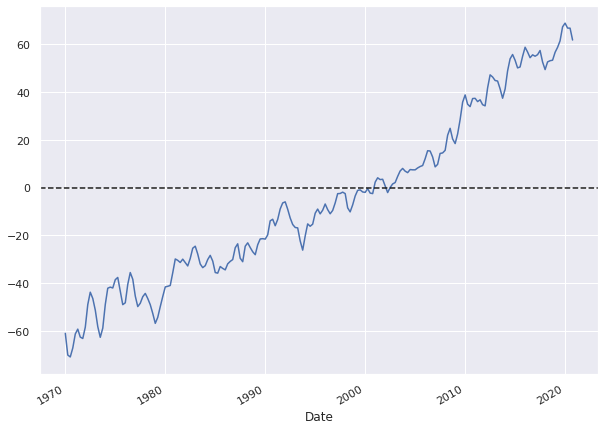

In [42]:
# Plotting the series
ax = df.plot(legend=None, figsize=(10,7.5))
plt.xlabel("Date")
ax.axhline(0, linestyle='--', color='k')
plt.show()

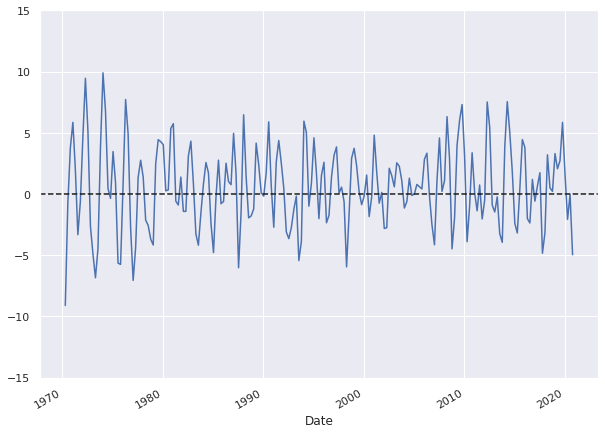

In [43]:
# Differencing to remove linear trend
df["diff"] = df[["sea_level_rise_uhslcfd"]].diff()

# Plotting the first difference
ax = df["diff"].plot(legend=None, figsize=(10,7.5))
plt.xlabel("Date")
plt.ylim(-15, 15)
ax.axhline(0, linestyle='--', color='k')
plt.show()

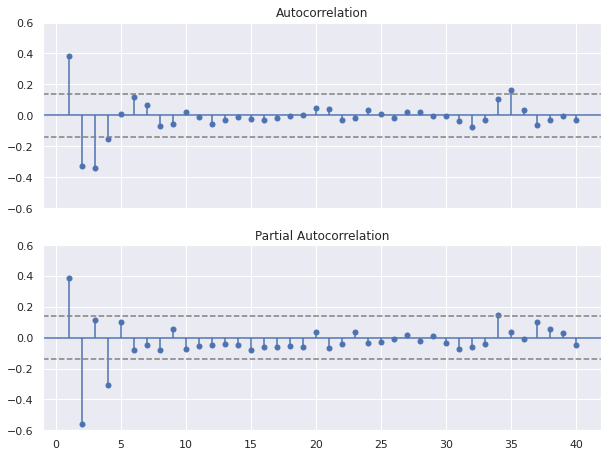

In [44]:
# Plotting the ACF and PACF
fig, axs = plt.subplots(2, figsize=(10,7.5), sharex=True)
plot_acf(df["diff"].dropna(), lags=40, ax=axs[0], alpha=None, zero=False)
plot_pacf(df["diff"].dropna(), lags=40, ax=axs[1], alpha=None, zero=False)
axs[0].set_ylim(-0.6, 0.6)
axs[0].set_xticks([0, 5, 10, 15, 20, 25, 30, 35, 40])
axs[1].set_ylim(-0.6, 0.6)

# "Confidence intervals" computed as done in EViews
axs[0].axhline(y=-1.96/np.sqrt(len(df["diff"].dropna())),linestyle='--',color='gray')
axs[0].axhline(y=1.96/np.sqrt(len(df["diff"].dropna())),linestyle='--',color='gray')
axs[1].axhline(y=-1.96/np.sqrt(len(df["diff"].dropna())),linestyle='--',color='gray')
axs[1].axhline(y=1.96/np.sqrt(len(df["diff"].dropna())),linestyle='--',color='gray')

plt.show()

In [45]:
# Here AIC is used to choose the number of lags
# To use SBC, pass autolag="BIC" into the test (the results are virtually the same)
# More on the parameters of the adfuller function: https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

# ADF test with no intercept, no trend
adfresult_n = adfuller(df["diff"].dropna(), regression="n")
print('ADF Statistic (no intercept, no trend): %f' % adfresult_n[0])
print('p-value: %f' % adfresult_n[1])
print('Critical Values:')
for key, value in adfresult_n[4].items():
	print('\t%s: %.3f' % (key, value))

# ADF test with intercept only
adfresult_c = adfuller(df["diff"].dropna(), regression="c")
print('\nADF Statistic (intercept only): %f' % adfresult_c[0])
print('p-value: %f' % adfresult_c[1])
print('Critical Values:')
for key, value in adfresult_c[4].items():
	print('\t%s: %.3f' % (key, value))

# ADF test with intercept and trend
adfresult_ct = adfuller(df["diff"].dropna(), regression="ct")
print('\nADF Statistic (intercept and trend): %f' % adfresult_ct[0])
print('p-value: %f' % adfresult_ct[1])
print('Critical Values:')
for key, value in adfresult_ct[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic (no intercept, no trend): -3.400743
p-value: 0.000689
Critical Values:
	1%: -2.578
	5%: -1.943
	10%: -1.615

ADF Statistic (intercept only): -5.211787
p-value: 0.000008
Critical Values:
	1%: -3.466
	5%: -2.877
	10%: -2.575

ADF Statistic (intercept and trend): -5.353105
p-value: 0.000045
Critical Values:
	1%: -4.008
	5%: -3.434
	10%: -3.141


In [46]:
# More on the parameters of the kpss function: https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.kpss.html

# KPSS test with intercept only
kpssresult_c = kpss(df["diff"].dropna(), regression="c")
print('KPSS Statistic (intercept only): %f' % kpssresult_c[0])
print('Critical Values:')
for key, value in kpssresult_c[3].items():
	print('\t%s: %.3f' % (key, value))

# KPSS test with intercept and trend
kpssresult_ct = kpss(df["diff"].dropna(), regression="ct")
print('\nKPSS Statistic (intercept and trend): %f' % kpssresult_ct[0])
print('Critical Values:')
for key, value in kpssresult_ct[3].items():
	print('\t%s: %.3f' % (key, value))

KPSS Statistic (intercept only): 0.134127
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739

KPSS Statistic (intercept and trend): 0.063955
Critical Values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
